In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setup

```
conda install -y numpy
conda install -y scipy
conda install -y matplotlib
conda install -y rasterio
pip install lmdb
conda install -y caffe
conda install -y protobuf==3.0.0b3
pip install tdqm
conda install -y fiona
conda install -y shapely
```

In [2]:
import logging
import os
import numpy as np
import rasterio as rio
import lmdb
from caffe.proto.caffe_pb2 import Datum
import caffe.io
from rasterio._io import RasterReader

In [6]:
from glob import glob

In [8]:
sources =glob('/home/shared/srp/try2/*.tif')
print len(sources)

1056


In [42]:
pos_regions = rasterio.open(r'/home/liux13/Desktop/tmp/pos_regions-epsg-26949.tif')

In [46]:
pos_mask = pos_regions.read(1) > 0
print pos_mask.shape, pos_mask.dtype

(7954, 8046) bool


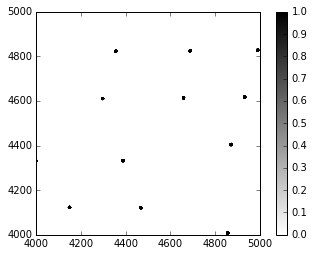

In [52]:
imshow(pos_mask[4000:6000, 4000:6000], extent=(4000,5000, 4000,5000), cmap=cm.binary)
colorbar();

In [10]:
from tqdm import tnrange, tqdm_notebook, 

In [164]:
points = []
for i in tnrange(len(sources)):
    ds = rasterio.open(sources[i])
    data = ds.read()
    mask = data.sum(0) > 1
    indices = np.nonzero(mask)
    xy = np.c_[ds.affine*(indices[1], indices[0])]
    pos_mask_indices = np.c_[~pos_regions.affine*xy.T].T.round().astype(int)
    
    pos_mask_indices = np.roll(pos_mask_indices, 1, 0)
    within_pos_mask = (pos_mask_indices[0] >= 0)  
    within_pos_mask = (pos_mask_indices[1] >= 0)  
    within_pos_mask &= (pos_mask_indices[0] < pos_mask.shape[0])
    within_pos_mask &= (pos_mask_indices[1] < pos_mask.shape[1])
    pos_mask_indices = pos_mask_indices[:, within_pos_mask]
    
    negative_mask = pos_mask[pos_mask_indices[0], pos_mask_indices[1]] == False
    
    xy = xy[within_pos_mask,:][negative_mask, :]
    points.append(xy)    

points= np.concatenate(points)

In [180]:
print "There are {:,d} negative examples".format(len(points))

There are 41,865,437 negative examples


In [167]:
import fiona
import shapely.geometry

In [174]:
vectors = fiona.open(r'/home/liux13/Desktop/tmp/boxes_section11.shp')
shapes = [shapely.geometry.shape(f['geometry']) for f in vectors if f['geometry'] is not None]
centers = np.row_stack([np.r_[s.centroid.xy] for s in shapes])

In [179]:
print "There are {:,d} positive examples".format(len(centers))

There are 196 positive examples


In [194]:
def get_angle(shape):
    verts = np.column_stack(s.xy)
    verts
    dx, dy = (verts[2]-verts[1])
    angle = np.degrees(np.arctan2(dy, dx))
    return angle
angles = np.r_[[get_angle(s) for s in shapes]]
print angles.astype(int)

[ -93 -156  -93  -34    0  -90    9   14    2    0    0 -124  140  -64  -36
   -3    0    0  -88    0  -32 -118  -30  -67  -33 -117  146   -7    2   -1
   -1    0    0 -106 -110    1    0  -89  -76  -74    0    0   -2   23   21
  112   26    5 -122   28  -69 -134    3 -124 -132   41   90    0    0    0
  -31   61  -32   26   90    3 -123  -27 -117  179   89   89 -148  -89  -90
  -90  -50   31   23   10   22  -45  179   -5    0   89    0   90    0    0
   -1   65  -88  -90   92  -86   91   90    0    0    1  -89  143  -20  -30
    1   -1   90   -4  -29  -28  -56  -89   90   88   89    1    0    0   -1
  178  -90  -66   -1    0  -89   -1   -1  179   14    0   -1    0   73    0
    0  -89   -1    0   -1    0  -87   27   13  117  116    0    0    0   27
   21   -1    1 -179    0    0    0  -15  -65    0  179    0    0   90    0
  -55  -52    8    0    0    0    0    0    0    0    0    1    0    0    0
    2   -1    0   90   89   91   91    0  -30    0   52  -43   59   55  114
   47]


In [195]:
np.savez('/home/shared/srp/sample_locations_epsg26949.npz', neg_xy=points, pos_xy=centers, pos_angles=angles)

# Reading in the ground truth locations

In [196]:
gt = np.load('/home/shared/srp/sample_locations_epsg26949.npz')

In [199]:
print gt.keys()`b

['pos_xy', 'neg_xy', 'pos_angles']


In [200]:
pos_xy = gt['pos_xy']
print pos_xy.shape

(196, 2)


# Plotting


This is how we can plot rasters with goerefernced vectors on top

First,  
```python 
import rasterio.plot
```

Then you can do this:

```python
figsize(15,15)
rasterio.plot.show( (pos_regions, 1), cmap=cm.binary_r, ax=gca())
xlim(232440.0, 232510.0)
ylim(252140.0, 252210.0)
scatter(xy[:,0], xy[:,1], lw=0, s=1)
scatter(pxy[:,0], pxy[:,1], lw=0, c='yellow')
```

The important part is the second line, where I pass a **tuple** with the datsaet and the band. 
Also important is I **pass the current axis in** to `rasterio.plot.show`.

In [205]:
np.random.randn(2)

array([-0.15910648,  0.60212988])